In [1]:
from pyemittance import emittance_calc

import numpy as np
from numpy import sin, cos, sinh, cosh, sqrt

# Create data

In [2]:
# Some beam covariance matrix

EMIT = 1e-9
BETA_X = 10
ALPHA_X = -1
GAMMA_X = (1+ALPHA_X**2)/BETA_X
SIGMA_X = sqrt(EMIT*BETA_X)
SIGMA_PX = sqrt(EMIT*GAMMA_X)
COV_X__PX = -ALPHA_X*EMIT


SIGMA_11 = SIGMA_X**2
SIGMA_12 = COV_X__PX
SIGMA_22 = SIGMA_PX**2

SIGMA0 = np.array([[SIGMA_11, SIGMA_12], [SIGMA_12, SIGMA_22]])

In [3]:
def thin_quad_mat2(kL):
    return np.array( [ [1, 0], [-kL, 1] ])

def drift_mat2(L):
    return np.array( [ [1, L], [0, 1] ])

def quad_mat2(kL, L=0):
    """
    Quadrupole transfer matrix, 2x2. Note that 
    
    """
    
    if L == 0:
        return thin_quad_mat2(kL)
    
    k = kL/L
    
    if k == 0:
        mat2 = drift_mat2(L)
    elif k > 0:
        # Focusing
        rk = sqrt(k)
        phi = rk*L
        mat2 =  [ [cos(phi), sin(phi)/rk], [-rk*sin(phi), cos(phi)] ]
    else:
        # Defocusing
        rk = sqrt(-k)
        phi = rk*L
        mat2 = [ [cosh(phi), sinh(phi)/rk], [rk*sinh(phi), cosh(phi)] ]
        
    return mat2

def quad_drift_mat2(kL, *, Ltot=2.0,  Lquad=0):
    """
    Composite [quad, drift] 2x2 transfer matrix. 
    """
    
    Ldrift = Ltot - Lquad
    
    return drift_mat2(Ldrift) @ quad_mat2(kL, Lquad)

def propagate_sigma(sigma_mat2, mat2):
    return (mat2 @ sigma_mat2) @ mat2.T

def beam_size_meas(kL, sigma0, Ltot=2.2, Lquad=0):
    
    mat2 = quad_drift_mat2(kL, Lquad=Lquad, Ltot=Ltot)

    sigma1 = propagate_sigma(sigma0, mat2)
    
    return np.sqrt(sigma1[0,0])

@np.vectorize
def model1(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0)

@np.vectorize
def model2(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0.108)

@np.vectorize
def model3(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26*1.1, Lquad=0.108)

kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model1(k) for k in kLlist])
meas2 =  np.array([model2(k) for k in kLlist])
meas3 =  np.array([model3(k) for k in kLlist])

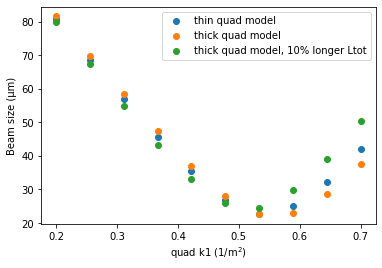

In [4]:
import matplotlib.pyplot as plt

plt.scatter(kLlist, meas1*1e6, label='thin quad model')
plt.scatter(kLlist, meas2*1e6, label='thick quad model')
plt.scatter(kLlist, meas3*1e6, label='thick quad model, 10% longer Ltot')
#plt.scatter(klist, meas3*1e6, label='thick quad model, 10% higher Lquad')
plt.xlabel(r'quad k1 (1/m$^2$)')
plt.ylabel('Beam size (µm)')
plt.legend()

# Fit data

In [5]:
from pyemittance.observer import Observer
from pyemittance.emittance_calc import EmitCalc

# Make the data
o1 = Observer(kLlist, {'x': meas3 ,'y': meas3} )

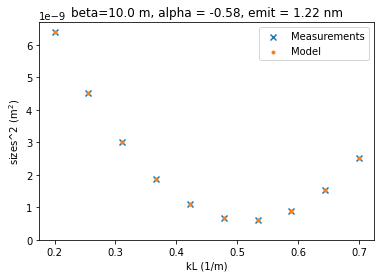

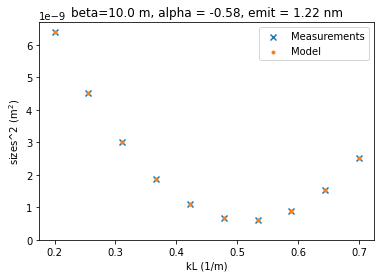

In [6]:
ef1 = EmitCalc(o1.quad_meas,o1.beam_meas)
emitx, erry = ef1.do_emit_fit(dim='x')
emity, erry = ef1.do_emit_fit(dim='y')